In [1]:
# builtins
import locale
import math
import glob
import pathlib
import functools
import logging

# numerical stuff
import pickle5 as pickle
import tables


In [2]:
# monkey patch the tables library to support pickle5, files were created using Python 3.8
tables.atom.pickle = pickle
tables.atom.pickle

<module 'pickle5' from '/home/guusvh/venvs/main/lib/python3.6/site-packages/pickle5/__init__.py'>

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Conv2DTranspose, Reshape
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, Input, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.python import ipu

# plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

logging.basicConfig(level=logging.INFO)

In [4]:
# Standard IPU TensorFlow setup.
ipu_config = ipu.config.IPUConfig()
ipu_config.auto_select_ipus = 4
ipu_config.configure_ipu_system()

# Create an execution strategy.
strategy = ipu.ipu_strategy.IPUStrategy()

In [13]:
data_path_train = 'gs://bathy_sample/processed/20211013/train_data_no_schematic'
data_path_test = 'gs://bathy_sample/processed/20211013/test_data_no_schematic'
meta_data_path = '/mnt/poddata/data/bathy-emodnet-a-runs.h5'
all_checkpoints_path = 'gs://bathy_sample/dnn/checkpoints'
all_checkpoints_path = '/mnt/poddata/data/checkpoints'
model_name = 'guus-2d-mlp-cnn-v0.5'
model_path = '/mnt/poddata/data/models'
learning_rate = 1e-4
n_epochs = 100
batch_size = 1
raster_shape = (256, 256, 1)
checkpoints_path = all_checkpoints_path + '/' + model_name
input_attributes = np.load('/mnt/poddata/data/input_attributes2.npy', allow_pickle=True).item()

In [14]:
def tf_parse(eg):
    """parse an example (or batch of examples, not quite sure...)"""

    # here we re-specify our format
    # you can also infer the format from the data using tf.train.Example.FromString
    # but that did not work
    example = tf.io.parse_example(
        eg[tf.newaxis],
        {
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'depth': tf.io.FixedLenFeature([], tf.int64),
            'bathy': tf.io.FixedLenFeature([], tf.string),
            'hs': tf.io.FixedLenFeature([], tf.string),
            'tm01': tf.io.FixedLenFeature([], tf.string),
            'theta0x': tf.io.FixedLenFeature([], tf.string),
            'theta0y': tf.io.FixedLenFeature([], tf.string),
            'eta': tf.io.FixedLenFeature([], tf.float32),
            'zeta': tf.io.FixedLenFeature([], tf.float32),
            'theta_wavex': tf.io.FixedLenFeature([], tf.float32),
            'theta_wavey': tf.io.FixedLenFeature([], tf.float32),
        },
    )
    bathy = tf.io.parse_tensor(example["bathy"][0], out_type="float32")
    bathy = tf.ensure_shape(bathy, raster_shape)
    hs = tf.io.parse_tensor(example["hs"][0], out_type="float32")
    hs = tf.ensure_shape(hs, raster_shape)
    tm01 = tf.io.parse_tensor(example["tm01"][0], out_type="float32")
    theta0x = tf.io.parse_tensor(example["theta0x"][0], out_type="float32")
    theta0y = tf.io.parse_tensor(example["theta0y"][0], out_type="float32")
    eta = example["eta"]
    zeta = example["zeta"]
    theta_wavex = example["theta_wavex"]
    theta_wavey = example["theta_wavey"]
    attr = tf.stack([eta, zeta, theta_wavex, theta_wavey], axis=1)
    attr = tf.reshape(attr,shape=[-1])
    output = (hs, tm01, theta0x, theta0y)
    output = hs
    return (bathy, attr), output

In [15]:
def get_files(data_path):
    files = tf.io.gfile.glob(data_path + "/" + "*.tfrecords")
    return files

def get_dataset(files):
    """return a tfrecord dataset with all tfrecord files"""
    dataset =  tf.data.TFRecordDataset(files)
    dataset = dataset.map(tf_parse)
    return dataset

In [16]:
def create_mlp(dim):
    input = Input(shape=dim)
    x = Dense(256, activation='relu')(input)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(4, activation='relu')(x)
    x = Dense(1, activation='relu')(x)

    model = Model(input, x)
        
    return model

def create_cnn(width, height, depth):
    input_shape = (height, width, depth)
    
    inputs = Input(shape=input_shape)
    x = Conv2D(16, (3,3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    ax = MaxPooling2D(pool_size=(2,2))(x)

    #Branch 1
    x = Conv2D(32, (3,3), padding="same")(ax)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    bx = MaxPooling2D(pool_size=(2,2))(x)

    #Branch 2
    x = Conv2D(64, (3,3), padding="same")(bx)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    cx = MaxPooling2D(pool_size=(2,2))(x)

    #Branch 3
    x = Conv2D(128, (3,3), padding="same")(cx)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(256, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(2,2))(x)
    x = Conv2DTranspose(256, (3,3), padding="same")(x)

    #Branch 2
    x = Concatenate()([x, cx])
    x = Conv2D(128, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2DTranspose(64, (3,3), padding="same")(x)

    #Branch 1
    x = Concatenate()([x, bx])
    x = Conv2D(32, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2DTranspose(16, (3,3), padding="same")(x)

    #Main Branch
    x = Concatenate()([x,ax])
    x = Conv2D(16, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(4, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(1, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    model = Model(inputs, x)
    
    return model
    
def full_model(cnn_input_shape, mlp_input_shape):
    
    mlp_input = Input(mlp_input_shape)
    with ipu.keras.PipelineStage(0):
        x = Dense(256, activation='relu')(mlp_input)
        x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        x = Dense(32, activation='relu')(x)
        x = Dense(16, activation='relu')(x)
        mlp_output = Dense(4, activation='relu')(x)
    
    cnn_input = Input(cnn_input_shape)
    
    with ipu.keras.PipelineStage(1):
        x = Conv2D(16, (3,3), padding="same")(cnn_input)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        ax = MaxPooling2D(pool_size=(2,2))(x)

        #Branch 1
        x = Conv2D(32, (3,3), padding="same")(ax)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        bx = MaxPooling2D(pool_size=(2,2))(x)

        #Branch 2
        x = Conv2D(64, (3,3), padding="same")(bx)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        cx = MaxPooling2D(pool_size=(2,2))(x)

        #Branch 3
        x = Conv2D(128, (3,3), padding="same")(cx)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Conv2D(256, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)

        x = UpSampling2D(size=(2,2))(x)
        x = Conv2DTranspose(256, (3,3), padding="same")(x)

        #Branch 2
        x = Concatenate()([x, cx])
        x = Conv2D(128, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = UpSampling2D(size=(2,2))(x)
        x = Conv2DTranspose(64, (3,3), padding="same")(x)

        #Branch 1
        x = Concatenate()([x, bx])
        x = Conv2D(32, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = UpSampling2D(size=(2,2))(x)
        x = Conv2DTranspose(16, (3,3), padding="same")(x)

        #Main Branch
        x = Concatenate()([x,ax])
        x = Conv2D(16, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Conv2D(4, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Conv2D(1, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        cnn_output = BatchNormalization()(x)
    
    with ipu.keras.PipelineStage(2):
        conv_shape = K.int_shape(cnn_output)

        x = Flatten()(cnn_output)
        x = Dense(64, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(16, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(4, activation="relu")(x)
        x = BatchNormalization()(x)

        x = Concatenate()([x,mlp_output])
        x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation="relu")(x)
        x = BatchNormalization()(x)

        x = Reshape((conv_shape[1],conv_shape[2],int(conv_shape[3])))(x)
    
    with ipu.keras.PipelineStage(3):
        x = Conv2D(16, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)

        x = Conv2D(64, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)

        x = Conv2D(128, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)

        x = Conv2D(256, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)

        x = UpSampling2D(size=(2,2))(x)
        x = Conv2DTranspose(256, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)

        x = UpSampling2D(size=(2,2))(x)
        x = Conv2DTranspose(64, (3,3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)

        x = UpSampling2D(size=(2,2))(x)
        x = Conv2DTranspose(1, (3,3), padding="same", activation="linear")(x)

    model = Model(inputs=[cnn_input, mlp_input], outputs = x)
    
    return model



In [17]:
train_files = get_files(data_path_train)
test_files = get_files(data_path_test)

train_dataset = get_dataset(train_files)
test_dataset = get_dataset(test_files)

train_dataset = train_dataset.batch(batch_size, drop_remainder=True).repeat()
test_dataset = test_dataset.batch(batch_size, drop_remainder=True).repeat()

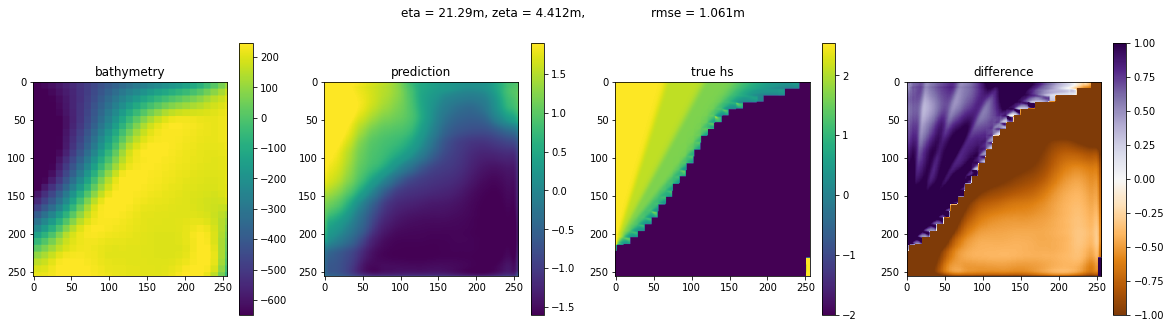

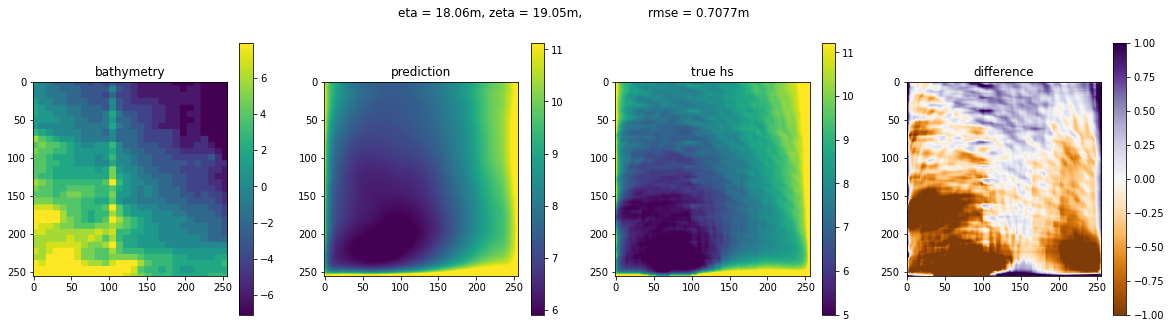

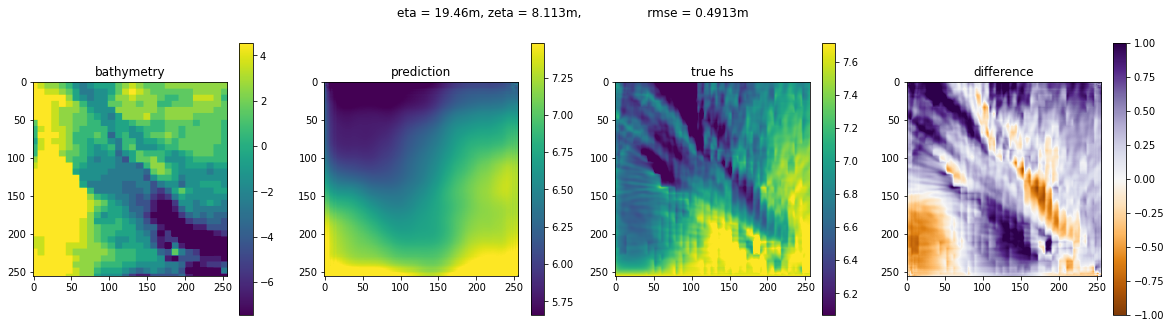

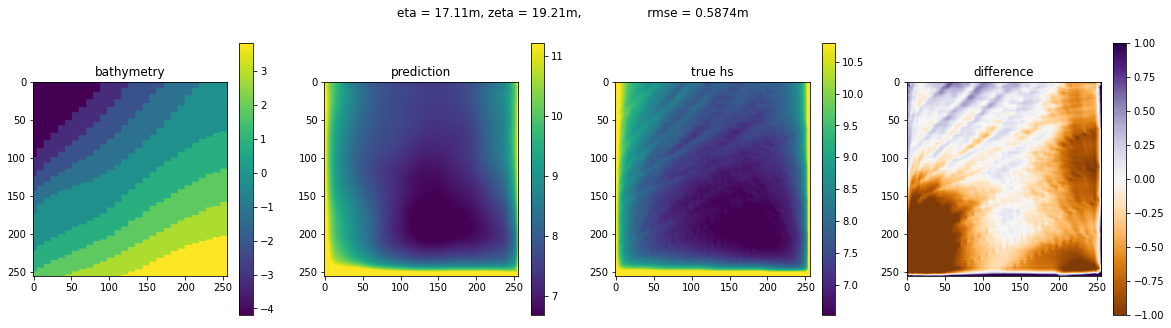

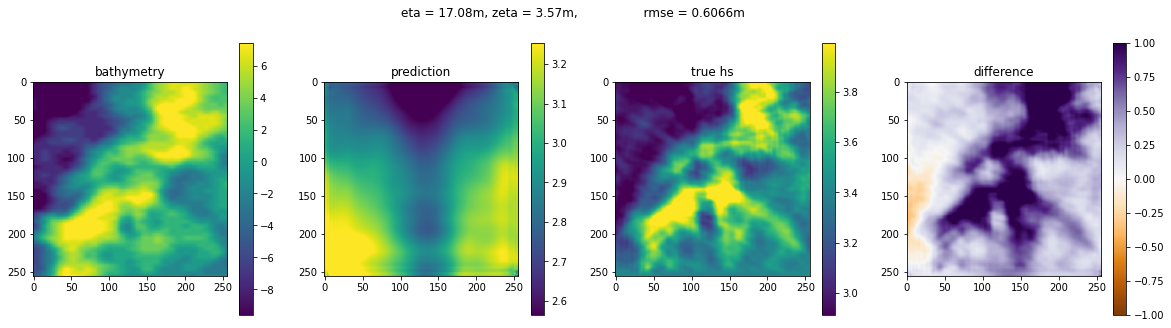

In [19]:
model = load_model(model_path + '/' + model_name + '.h5')
# Get the mean and std of the input before standardization
(eta_mean, eta_std) = input_attributes['eta'].values()
(zeta_mean, zeta_std) = input_attributes['zeta'].values()
(bathy_mean, bathy_std) = input_attributes['bathy'].values()

ls = LightSource(azdeg=315, altdeg=45)
#im = axes[0].imshow(ls.hillshade(bathy.numpy()))

skip_count = 2
index = 0
for sample in test_dataset.skip(skip_count*5).take(5):
    # sample is a tuple of (input, output)
    (input, output) = sample
    bathy = input[0][index,...,0]*bathy_std + bathy_mean # take bathymetry from input tuple
    (eta, zeta, theta_wavex, theta_wavey) = input[1][index,:] # take attributes from input tuple
    prediction = model.predict(input)[index][:,:,0] # take first element of the batch and take the first and only channel
    true_hs = output[index][:,:,0]
    (vmin, vmax) = np.percentile(true_hs, [5, 95])
    (vmin2, vmax2) = np.percentile(bathy, [5, 95])
    (vmin3, vmax3) = np.percentile(prediction, [5, 95])
    
    fig, axes = plt.subplots(figsize=(20,5), ncols=4)
    fig.suptitle(f'eta = {eta*eta_std + eta_mean:.4}m, zeta = {zeta*zeta_std + zeta_mean:.4}m,\
                 rmse = {np.sqrt(tf.reduce_mean((true_hs - prediction)**2)):.4}m')

    axes[0].set_title('bathymetry')
    im = axes[0].imshow(bathy, vmin=vmin2, vmax=vmax2)
    plt.colorbar(im, orientation='vertical', ax=axes[0])
    
    axes[1].set_title('prediction')
    im = axes[1].imshow(prediction, vmin=vmin3, vmax=vmax3)
    plt.colorbar(im, orientation='vertical', ax=axes[1])
    
    axes[2].set_title('true hs')
    im = axes[2].imshow(true_hs, vmin=vmin, vmax=vmax)
    plt.colorbar(im, orientation='vertical', ax=axes[2])
    
    axes[3].set_title('difference')
    im = axes[3].imshow(true_hs - prediction, cmap='PuOr', vmin=-1, vmax=1)
    plt.colorbar(im, orientation='vertical', ax=axes[3])
    
    
    plt.show()
    #print(sample[0])

In [ ]:
bathy = input[0][index,...,0]*bathy_std + bathy_mean
plt.imshow(bathy)
plt.axis('off')

In [ ]:
with strategy.scope():
    #mlp_model = create_mlp(4)
    #cnn_model = create_cnn(256, 256, 1)
    
    model = full_model((256, 256, 1), 4)
    opt = Adam(learning_rate=learning_rate, decay=learning_rate / n_epochs)
    model.compile(loss="mean_squared_error", optimizer=opt, steps_per_execution=32)
    
    callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoints_path, 
        save_weights_only=True,
        #monitor='val_mse',
        mode='max',
        save_best_only=True
    )
    ]
    
    model.set_gradient_accumulation_options(
        gradient_accumulation_steps_per_replica=8)
    model.set_pipelining_options(
        gradient_accumulation_steps_per_replica=8)
    model.fit(x=train_dataset, validation_data=test_dataset, epochs=n_epochs, steps_per_epoch=896,
             validation_steps=320, callbacks=callbacks)
    model.save(model_path+'/'+model_name+'.h5')

Epoch 1/100
896/896 [==============================] - 961s 1s/step - loss: 31.4690 - val_loss: 32.2289
Epoch 2/100
896/896 [==============================] - 61s 68ms/step - loss: 19.7239 - val_loss: 10.4079
Epoch 3/100
896/896 [==============================] - 66s 73ms/step - loss: 9.9737 - val_loss: 9.5146
Epoch 4/100
896/896 [==============================] - 57s 63ms/step - loss: 13.4381 - val_loss: 6.7000
Epoch 5/100
896/896 [==============================] - 59s 65ms/step - loss: 7.8210 - val_loss: 4.3686
Epoch 6/100
896/896 [==============================] - 67s 75ms/step - loss: 7.5800 - val_loss: 4.3317
Epoch 7/100
896/896 [==============================] - 62s 69ms/step - loss: 7.3862 - val_loss: 3.3795
Epoch 8/100
896/896 [==============================] - 65s 73ms/step - loss: 6.3136 - val_loss: 3.9888
Epoch 9/100
896/896 [==============================] - 46s 52ms/step - loss: 3.1608 - val_loss: 3.7250
Epoch 10/100
896/896 [==============================] - 66s 74ms/step

In [11]:
cnn_model = create_cnn(256, 256, 1)
mlp_model = create_mlp(3)

In [12]:
model = full_model(cnn_model, mlp_model)
opt = Adam(learning_rate=learning_rate, decay=learning_rate / n_epochs)

model.compile(loss="mean_squared_error", optimizer=opt, metrics=['mse'])

In [ ]:
logging.info("training model...")
# TODO properly compute steps for progress bar (low priority)
steps_per_epoch = len(train_files) * 10 // batch_size

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoints_path, 
        save_weights_only=True,
        monitor='val_mse',
        mode='max',
        save_best_only=True
    )
]
model.fit(x=train_dataset, validation_data=test_dataset, epochs=n_epochs, callbacks=callbacks)

In [33]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 256, 256, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 256, 256, 16) 0           conv2d_14[0][0]                  
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 256, 256, 16) 64          activation_16[0][0]              
____________________________________________________________________________________________

In [13]:
pd.read_hdf(meta_data_path)

,$\zeta$,$\theta_{wave}$,$\eta$,$bathy_i$,bathy_file,bathy,uuid,run_id,bathy_source
0,1.000000,0.000000,1.000000,0,/p/11207539-001-undeepwaves/emodnet/bathymetry...,"[[-1.2872086, -1.2872086, -1.2872086, -1.48720...",88c98d1f-6307-43b5-a8bd-0cc6b23e105e,a,emodnet
1,1.000000,0.000000,1.000000,462,/p/11207539-001-undeepwaves/emodnet/bathymetry...,"[[-13.052446, -12.792448, -12.792448, -12.5124...",b38a89ab-f021-42dc-808e-e116dd924a46,a,emodnet
2,1.000000,0.000000,50.000000,0,/p/11207539-001-undeepwaves/emodnet/bathymetry...,"[[-1.2872086, -1.2872086, -1.2872086, -1.48720...",318908b3-1ed1-4117-8226-6eaeb2846a24,a,emodnet
3,1.000000,0.000000,50.000000,462,/p/11207539-001-undeepwaves/emodnet/bathymetry...,"[[-13.052446, -12.792448, -12.792448, -12.5124...",dee4ae77-a3af-4e73-9f16-54b7ac589158,a,emodnet
4,1.000000,6.283185,1.000000,0,/p/11207539-001-undeepwaves/emodnet/bathymetry...,"[[-1.2872086, -1.2872086, -1.2872086, -1.48720...",e7bb6f7b-69db-4515-9dcf-6dc009d4d775,a,emodnet
...,...,...,...,...,...,...,...,...,...
1011,13.282544,3.631269,8.666409,100,/p/11207539-001-undeepwaves/emodnet/bathymetry...,"[[-21.735966, -21.735966, -21.635967, -21.6359...",65382ebd-1b80-4d75-9287-8bb7f2a41db0,a,emodnet
1012,13.581516,2.358778,29.419263,402,/p/11207539-001-undeepwaves/emodnet/bathymetry...,"[[6.6918297, 6.6918297, 6.6918297, 6.6918297, ...",0402bcb5-7309-4662-8a18-93f1dccde9b4,a,emodnet
1013,8.416452,5.184157,14.352605,151,/p/11207539-001-undeepwaves/emodnet/bathymetry...,"[[-1.3258033, -1.3258033, -1.3258033, -1.32580...",065553d1-f60d-4d7e-997e-0b07747682be,a,emodnet
1014,1.511433,5.741217,39.150158,367,/p/11207539-001-undeepwaves/emodnet/bathymetry...,"[[20.617117, 20.617117, 20.017117, 20.017117, ...",06577167-1089-49f4-aea7-2f736f9398ca,a,emodnet
